## Chapter 3. Classification

Notes taken from [here](https://www.safaribooksonline.com/library/view/hands-on-machine-learning/9781491962282/ch03.html#classification_chapter).

Original notebook available [here](https://github.com/ageron/handson-ml/blob/master/03_classification.ipynb).

---

Chapter 2 looked at a regression problem, showcasing algorithms:
- Linear Regression
- Decision Trees
- Random Forest

Now we will look at some classification algorithms and techniques.

### MNIST

*(Modified National Institute of Standards and Technology database)*

A set of 70,000 images of small digits (0-9), each labeled with the digit it represents. Considered the 'hello-world' of classification machine learning.

Let's start off by grabbing the data:

In [1]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='./tmp')

In [2]:
X, y = mnist["data"], mnist["target"]
print(mnist.DESCR)
print(X.shape)
print(y.shape)

mldata.org dataset: mnist-original
(70000, 784)
(70000,)


We can see there are 70,000 data-points each with 784 columns and 70,000 labels. There are 784 columns because they are 28x28 images. Let's look at one:

In [3]:
X[0].reshape(28,28)[:5]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  51, 159, 253, 159,  50,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=uint8)

So it's a 28x28 grid of numbers 0..255 indicating the intensity of the grey at that pixel. Let's look at one digit:

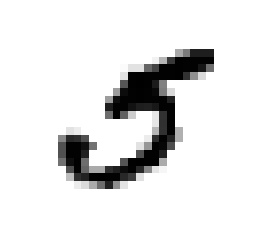

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()

In [5]:
y[36000]

5.0

It looks like a 5, and the label is a 5.

The MINST dataset is already split into training (60,000) and test (10,000) entries, so let's separate those.

Also, the data is organized by digit, but we should randomize the order as some algorithms are sensitive to pre-sorted data:

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [7]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

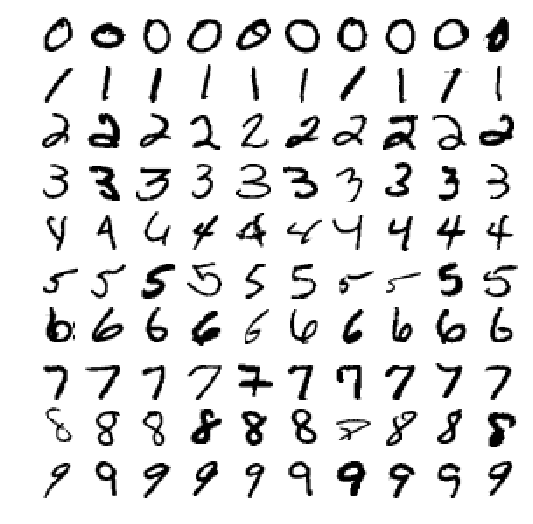

In [8]:
plt.figure(figsize=(9,9))
# 20, 30, and 50 images (100 images total)
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

### Training a Binary Classifier

We'll simplify this to start by identifying simply as '5' or 'not-5'. Let's create labels to test against:

In [9]:
y_train_5 = (y_train == 5)  # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

And let's train a SGDClassifier (Stochastic Gradient Descent) on it. SGD relies on randomness, so if we want consistent results we should seed the RNG manually:

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [11]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

Looks like it's correctly identifying our 5!

### Performance Measures

Measuring performance of a classifier can be much trickier than performance of a regressor. 

#### Measuring Accuracy Using Cross-Validation

We can use X-Validation just like in Chapter 2:

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9564 ,  0.96425,  0.96945])

~ 95% accuracy seems good, but also 10% of items are 5 anyways. We can create a classifier that classifies everything as not-5 for comparison:

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9075 ,  0.913  ,  0.90845])

As expected this stupid classifier is right over 90% of the time! This shows why 'Accuracy' is not always the most important metric when measuring classifier performance.

#### Confusion Matrix

Counts the number of times each category is classified as itself, and every other category. Allows you to see which things are being confused for others.

We first need predictions to compute the matrix:

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53935,   644],
       [ 1554,  3867]])

Rows represent actual classes, and columsn represent predicted classes. Here, ~52,000 non-5s were classified as non-5s, and ~2100 were classified as 5's. ~1270 5s were classified as non-5's, and ~4100 5's were classified correctly as 5's.

A more concise way to view results is looking at 'precision' and 'recall'.

*Precision*: The accuracy of the positive predictions. 
*Recall*: The ratio of positive predictions detected by the classifier, aka 'sensitivity' or 'true positive rate' (TPR).

#### Precision and Recall

We can calculate precision and recall directly:

In [16]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.857237863002
0.71333702269


precision and recall can be combined into a single score call F1 score. It is only high if both precision and recall are high. Sometimes, you are more focused on precision or recall though, and F1 may not be appropriate:

In [17]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.77869512686266618

#### Precision/Recall Tradeoff

SGD is making a decision to classify +ve/-nve based on some threshold (it happens to be 0). We can't set the treshold directly but we can see the scores it calculates for each instance:

In [18]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

[ 130829.22395885]


array([ True], dtype=bool)

The value is well above 0 for this '5'. If we increased the threshold to something like 200,000, then it would not be classified as a positive.

We can see how precision and recall relate as the threshold changes:


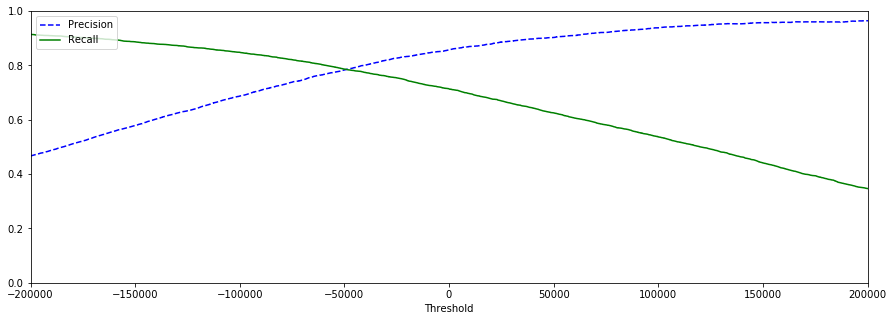

In [19]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(15, 5))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    plt.xlim([-200000, 200000])
    

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

we can also plot precision against recall:

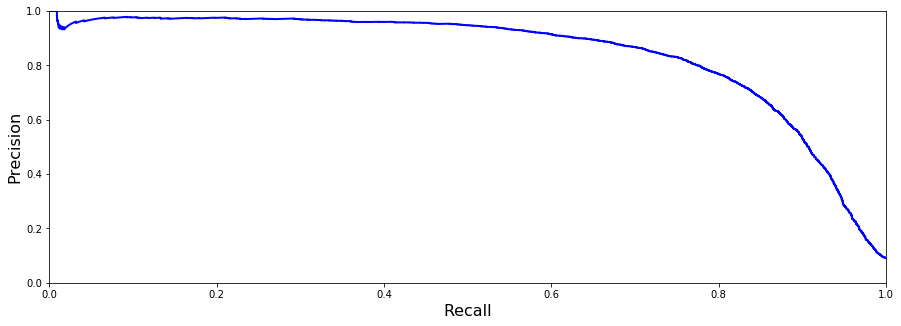

In [20]:
def plot_precision_vs_recall(precisions, recalls):
    plt.figure(figsize=(15, 5))
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

assuming we wanted ~90% precision we can look at 1st plot above and see that 90% precision occurs around a threshold of ~70,000. We can then make our predictions based on that as we have a decision score for every point:

In [21]:
y_train_pred_90 = (y_scores > 70000)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.918965517241
0.589928057554


as expected precision is around 90% and recall isn't great.

#### The ROC Curve

receiver operating characteristic (ROC). Instead of plotting precision vs. recall it plots 'true positive rate' (recall) against false positive rate. FPR aka 1 minus 'true negative rate' or TNR. TNR aka specificity. I guess this enures that it's plotting positives as positives and negatives as negatives.

roc plots sensitivity vs. 1 - specificity.

we can get TPR and FPR and plot them:

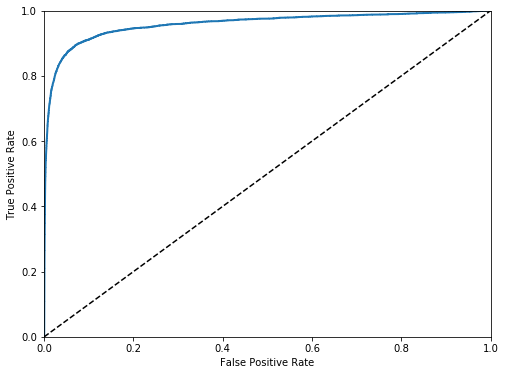

In [22]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

There is a tradeoff here too; a High TPR means a high FPR. A way to summarize this chart is to find the area under the curve (AUC). Perfect AUC would be 1, and random would be 0.5 (the dotted line). What's ours here?

In [23]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.95888487658980459

How to know when to use ROC-AUC and when to use PR curves?

Generally, prefer PR whenever positive class is rare, or you care more about false positives than false negatives, and ROC otherwise.

Let's try a randomforestclassifier and see how it compares. It doesn't have 'decision_function', but instead has 'predict_proba' method. For ROC we need scores, not probabilities. We can use the positive class's probabilty as the score:

In [24]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [25]:
y_scores_forest = y_probas_forest[:, 1]   # score = proba of positive class. This slices all rows, and the 2nd column.
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

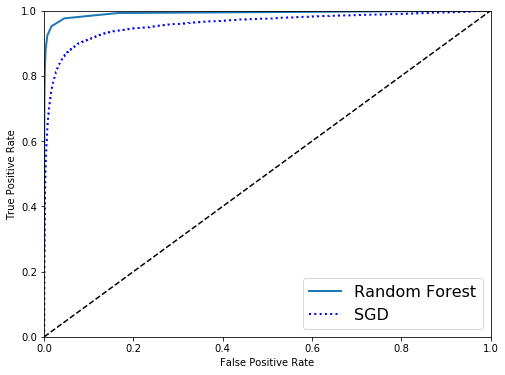

In [26]:
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [27]:
print(roc_auc_score(y_train_5, y_scores_forest))

0.992407962776


Random Forest looks much better!

### Multiclass Classification

Binary classifiers distinguish between 2 classes.

Multiclass (multinomial) classifiers distinguish between more than 2 classes.

Some algorithms can natively handle multiple classes, and others are only binary. However, there are ways to use binary classifers for multiclass classification.

One way is to clain a classifier for every class (here we would have 10, is_1, is_2, etc.). Then, when making a prediction you run all 10 and choose one with the best score. This is called One-vs-All (OvA) or One-vs-the-rest.

Another way is to train  N × (N – 1) / 2  classifiers for n_classes. Here, 0vs1, 0vs2... 1vs2, 1vs3.. up to 8vs9. Then, to make predictions you run it through all classifiers and see which class wins the most. It's called One versus One (OvO). This requires lots of classifiers, but you only have to train them on smaller sets. Ie, 0vs1 would only train on the inputs labeled as 0 or 1 and could ignore 80% of training data. For algorithsm that scale poorly this would be helpful.

Scikit detects when you try to use a binary classifier for multi-label classification and automatically runs OvA (except for SVM with which it will use OvO):



In [28]:
sgd_clf.fit(X_train, y_train)  # y_train, not y_train_5
sgd_clf.predict([some_digit])
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)
print(np.argmax(some_digit_scores))
print(sgd_clf.classes_)
print(sgd_clf.classes_[5])

[[-258305.26069152 -359921.96062775 -637967.58774001 -168935.77541144
  -429517.45645529  130829.22395885 -765343.27220156 -255246.86625963
  -768266.99699562 -532171.4939984 ]]
5
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
5.0


You can see it trained 10 classifiers as we have 10 scores, with index 5 having the highest. Are classes just happen to be the same as the indices here, but in other cases we would see the actual labels when calling *.classes_*.

You can manually force scikit to use 'OneVsOneClassifier' or 'OneVsRestClassifier' as such: You can see it produced N X (N-1) / 2 classifers.

In [29]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit]))
print(len(ovo_clf.estimators_))

[ 5.]
45


Let's train a classifer that can natively predict multiple classes:

In [30]:
forest_clf.fit(X_train, y_train)
print(forest_clf.predict([some_digit]))
print(forest_clf.predict_proba([some_digit]))

[ 5.]
[[ 0.1  0.   0.   0.1  0.   0.8  0.   0.   0.   0. ]]


It's about 90% sure it's a 5, but 10% chance it could be a 0.

Let's check how well SGD performs in x-val:

In [31]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.8709758 ,  0.86589329,  0.85502825])

~85% isn't bad, as random would just be 10%. Surely we could improve. By simply adding a scalar the performance improves:

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.91116777,  0.90894545,  0.90693604])

### Error Analysis

It can be useful to see what kinds of errors your model makes. Let's look at the confusion matrix:

In [33]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5741,    3,   19,   12,   10,   41,   48,    9,   37,    3],
       [   2, 6483,   45,   26,    6,   40,    7,   12,  109,   12],
       [  61,   40, 5320,  109,   88,   22,  102,   51,  148,   17],
       [  55,   46,  132, 5344,    2,  240,   35,   58,  123,   96],
       [  25,   29,   32,   10, 5373,   10,   57,   32,   72,  202],
       [  68,   43,   31,  178,   85, 4618,  117,   25,  167,   89],
       [  34,   22,   38,    2,   53,   94, 5631,    4,   40,    0],
       [  26,   20,   66,   34,   53,   10,    4, 5794,   16,  242],
       [  47,  175,   78,  164,   13,  165,   56,   34, 4983,  136],
       [  47,   39,   28,   87,  179,   38,    2,  208,   67, 5254]])

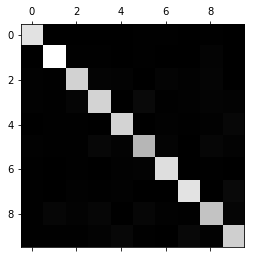

In [34]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

this matrix looks pretty good, as most images are on the diagonal. We can get a better view by looking at the error rates:

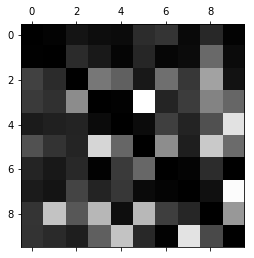

In [35]:
# we want the total number of images per row for use in rate calc.
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# and we can fill the diagonal with 0's to ignore the true positives.
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

We can see many things are misclassified as 8 or 9. Also, 5's are often classified as 3's and vice-versa. Let's look at the 3's and 5's more closely:

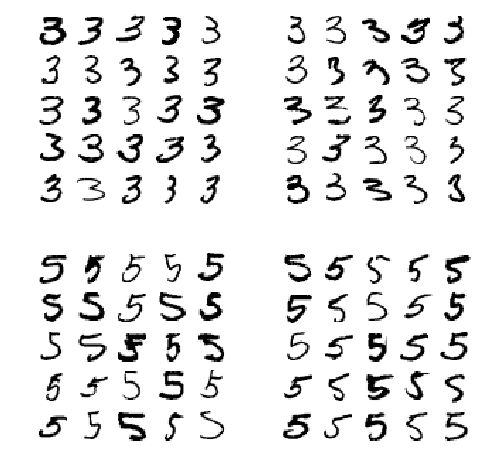

In [36]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
# subplot notation: 3 digits: Rows, Columns, Subplot. So, here we have a 2x2 subplot, with items 1 through 4.
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

Top left and bottom right are true positives. Top right is 3's predicted as 5's, and bottom left are 5's predicted as 3's. Apparently a big reason for the failure here is that we used a linear classifier that only looks at pixel densities. If we scaled/rotated and preprocessed it might help.

### Multilabel Classification

Until now we've only looked at classifers that give one output per instance. An algorithm that can give multiple outputs (ie which people are in a picture) is considered multilabel classification system.

We can explore this with a simple multilabel test. Let's classify images at either > 7 or odd:


In [37]:
# #  this is taking too long
# from sklearn.neighbors import KNeighborsClassifier

# y_train_large = (y_train >= 7)
# y_train_odd = (y_train % 2 == 1)
# y_multilabel = np.c_[y_train_large, y_train_odd]

# knn_clf = KNeighborsClassifier()
# knn_clf.fit(X_train, y_multilabel)

Now we can make predictions:

In [38]:
# knn_clf.predict([some_digit])

And it's right! 5 is not greater or equal to 7, and it is odd.

There are many ways to evaluate a multi-label classifier. One is to compute average F1 score over all labels:

In [39]:
#  this is taking too long

# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
# f1_score(y_train, y_train_knn_pred, average="macro")

The above assumes all labels are equally important. Another way to do this is to give weight based on the support, ie the # of items with that label. This can be done by setting average="weighted" in the previous code.

### Multioutput Classification

Each label can be multiclass.

To illustrate we'll build a model to remove noise from images.
Each output is multilabel (array of pixels), and each pixel can be a range of intensities. 

Let's add noise ot the original image. The targets will be the original images.

In [41]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

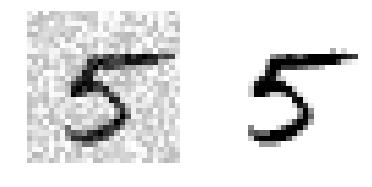

In [52]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()